# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

# Данные

Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.filterwarnings("ignore")

num_samples = 1000000
anime_samples = 1000

data = pd.read_csv("rating.csv")

data = data.head(num_samples)
data_array = data.values

anime = pd.read_csv("anime.csv")
anime = anime[anime["anime_id"] < anime_samples]

### ``` Если вычеслительные ресурсы не позволяют решить задачу на всех данных, то необходимо это сделать на "сэмпле" данных (выбрав от 5% ids' для user и item). Этот же подход справедлив и для оценки работы алгоритомв```

## Необходимо сделать:

### Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Разпределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

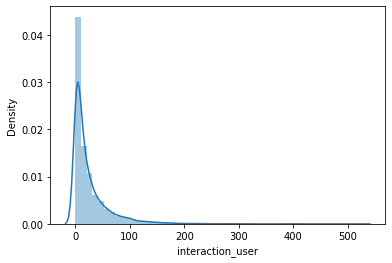

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

unique_users = data["user_id"].unique().size
matrix = np.zeros(
    (unique_users, anime_samples), 
    np.int16)

c = [0] * anime_samples

for item in anime.values:
    c[ item[0]-1] =  item[1]

matrix_data = pd.DataFrame(matrix, columns=c)

for r in data_array:
    if r[1] <= anime_samples:
        matrix[r[0] - 1][r[1] - 1] = r[2]
        
def fig(data):
    sns_plot = sns.distplot(data)
    fig = sns_plot.get_figure()
    
n = np.zeros(unique_users)

for i, x in enumerate(matrix_data.values):
    n[i] += np.count_nonzero(x)

matrix_data["interaction_user"] = n


fig(matrix_data["interaction_user"])

<AxesSubplot:>

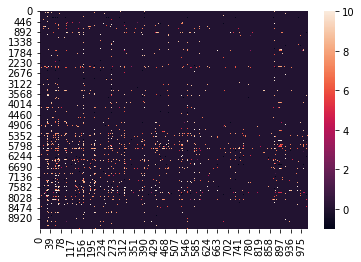

In [3]:
sns.heatmap(matrix)

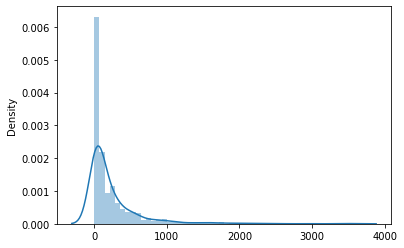

In [4]:
animen = np.zeros(anime_samples)

for i in range(anime_samples):
    x = matrix[:, i][matrix[:, i]!=0]
    animen[i] += np.count_nonzero(x)
    
fig(animen)

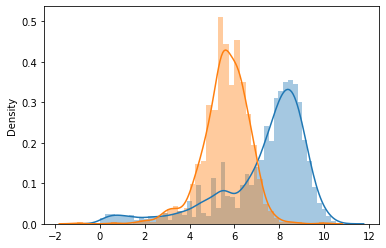

In [5]:
userr = np.zeros(unique_users)
animerr= np.zeros(anime_samples)

for i, x in enumerate(matrix_data.values):
    userr[i] = np.mean(x[x!=0])
    
for i in range(anime_samples):
    elem = matrix[:, i][matrix[:, i]!=0]
    animerr[i] = np.mean(elem)
    
fig(userr[userr != 0])
fig(animerr)

### Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

0.025742893780722375  is nonzero elements in matrix of data


<AxesSubplot:>

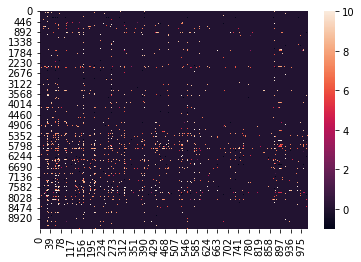

In [6]:
sparse = 0

num = np.count_nonzero(matrix)

denom = matrix.size

print(num/denom, " is nonzero elements in matrix of data")

sns.heatmap(matrix)

### Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

In [7]:
train_users = 9000
matrix_train, matrix_val = matrix[:train_users], matrix[train_users:]

### Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

Чтобы хоть как то вариативно решать задачу, будем брать рандомные популярные

In [8]:
def dummy_model(user_id, k):
    user_id -= train_users
    samples = 100
    
    var = matrix[np.random.choice(len(matrix), size=samples, replace=False)]
    rating = np.zeros(1000)
    for x in range(1000):
        rating[x] = np.sum(var[:, x])
        
    return np.argpartition(rating, -k)[-k:]
    
dummy_model(9300, 5)

array([333, 330, 332, 334, 999], dtype=int64)

### Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

In [9]:
def get_k_ind(array, k):
    return np.argpartition(array, -k)[-k:]

In [10]:
from numpy.linalg import svd

k = 50

u, d, v = svd(matrix_train)

U = u[:, :k]
D = np.diag(d)[:k, :k]
V = v[:k, :]

uv, dv, vv = svd(matrix_val)

Uv = uv[:, :k]
Dv = np.diag(dv)[:k, :k]
Vv = vv[:k, :]


In [11]:
recomendations_val = Uv @ D @ V
recomendations_train = U @ D @ V

In [12]:
def svd_model(user_id, k, val=True):
    
    if val:
        pred = recomendations_val[user_id - train_users]
    else:
        pred = recomendations_train[user_id]
        
    return get_k_ind(pred, k)
    

In [13]:
svd_model(4567, 7, False)

array([745,  60, 242, 148, 849, 119, 852], dtype=int64)

### Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения (2 балла):

* На основание векторов с факторизационной матрицы
* При помощи "ембеддингов"  item'ов

In [14]:
import torch
from torch import nn

dev = torch.device("cuda:0")

class FactorNet(nn.Module):
    def __init__(self, k_users):
        
        super().__init__()
        
        self.k_users = k_users
        
        self.emb_user = nn.Embedding(k_users, 32)
        
        self.emb_anime = nn.Embedding(1000, 32)
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.filtration = nn.Sequential(
            nn.LazyLinear(256),
            nn.ELU(),
            nn.LazyLinear(128),
            nn.ELU(),
            nn.LazyLinear(1),
        )
        
    def forward(self, batch):
        user_v = np.zeros((len(batch), self.k_users))
        anime_v = np.zeros((len(batch), 1000))
        
        for i, x in enumerate(batch):
            if x[1] - 1 < 1000:
                user_v[i][x[0] - 1] = 1
                anime_v[i][x[1] - 1] = 1
            
        user = torch.from_numpy(user_v).long().to(dev)
        anime = torch.from_numpy(anime_v).long().to(dev)
        
        user_emb = self.emb_user(user).permute(0, 2, 1)
        anime_emb = self.emb_anime(anime).permute(0, 2, 1)
        
        us = self.flatten(user_emb)
        an = self.flatten(anime_emb)
        
        features = torch.cat([us, an], dim=1)
        answer = self.filtration(features)
        return answer.squeeze()
        


class EmbeddingNet(nn.Module):
    pass

In [15]:
dev = torch.device("cuda:0")

model = FactorNet(len(matrix)).to(dev)

In [16]:
batch = [
    np.array([4, 9, 32]),
    np.array([345, 234, 100])
]

In [17]:
model(batch)

tensor([0.1621, 0.1549], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [31]:
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

class CustomDataset(Dataset):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx][:2], self.data[idx][2]

train = CustomDataset(data.values[:900000])
val = CustomDataset(data.values[900000:])

train_loader = DataLoader(train, batch_size=256)
val_loader = DataLoader(val, batch_size=256)


def train(model, epochs=10, lr=0.001, cr=torch.nn.MSELoss()):
    
    losses_train = []
    losses_val = []
    mse = []
    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    for ep in range(epochs):
        model.train()
        
        train_loss = 0
        c = 0
        
        for batch in tqdm(train_loader):
            
            c += 1
            
            labels = batch[1].float().cuda()
            
            out = model(batch[0].cuda())
            
            opt.zero_grad()
            
            loss = cr(out, labels)
            
            loss.backward()
            
            train_loss += loss.item()
            
            opt.step()
            
            losses_train.append(loss.item())
            
#             print(f"Train loss {loss.item()}")
            
        train_loss /= c
        
        loss_mean = 0
        c = 0
            
        for batch in tqdm(val_loader):
            
            c += 1
            
            model.eval()
            
            labels = batch[1]
            
            out = model(batch[0].cuda())
            
            with torch.no_grad():
            
                loss = cr(out, labels)
                
#                 print(f"Val loss {loss.item()}")
                
                loss_mean += loss.item()
                
        loss_mean /= c
        
        print(f"Epoch {ep + 1} | train loss: {train_loss} | val loss: {los_mean}")
                
                
            
            
            

    

In [33]:
# train(model)


# Оч долго обучалось, а в конце вылетела CUDA MEMORY ERROR, я не стал перезапускать

In [ ]:
for x in train_loader:
    a = x
    break

In [ ]:
a[0].shape

### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

In [35]:
import warnings
# !pip install ml_metrics

from ml_metrics import mapk

In [64]:
val_users = np.array([9123, 9322, 9228, 9111, 9231])

val_users -= 9000
k = 8

r = Uv@Dv@Vv

val_pop = np.array([get_k_ind(r[x], k) for x in val_users])

val_users += 9000

svd_pred = np.array([svd_model(x, k, True) for x in val_users])
           
           

ncf_pred = None

model = model.cpu()

def get_ncf(users):
    model.eval()
    batch = []
    for x in range(5):
        batch.append(
            model(
                torch.tensor(
                   [ [users[x], i] for i in range(1000) ]
                )
            ).cpu().detach().numpy()
        )
#     print(batch)
    return [get_k_ind(batch[i], k) for i in range(len(users))]

ncf_pred = get_ncf(val_users)

In [ ]:
# torch.cuda.empty_cache()

In [62]:
mapk(svd_pred.tolist(), val_users.tolist(), k)

0.7986348122866894


In [63]:
mapk(ncf_pred.tolist(), 
    val_users.tolist(), k)

0.7029733477122169


In [50]:
ncf_pred

[[342, 336, 330, 334, 333, 332, 331, 999],
 [46, 848, 5, 522, 58, 198, 430, 19],
 [64, 848, 355, 23, 63, 845, 5, 456],
 [19, 856, 231, 268, 354, 848, 225, 551],
 [30, 776, 269, 225, 355, 31, 0, 29]]

``` Бонус (1 балл) - дополнительные графики и характеристики в EDA и правильно сделанные выводы```

# ```ВЫВОДЫ```

Вообще, SVD мне показался в плане предсказаний вполне репрезентативным алгоритмом, правда значения выходили за пределы от 0 до 10, но тем лучше можно было понять предпочтения пользователя, если число было больше. Отрицательные значения можно интерпретировать как "посмотрел и не поставил отзыв", так и "не понравилось". Эту информацию, к сожалению, получить нельзя. 

Нейронная коллаборативная фильтрация на основе эмбедингов хорошо решила задачу. Но рекомендации порой неоправданы, хотя и логичны, исходя из того или иного пользователя.

Модель выбора самых популярных даже рядом не стоит, так как дает слишком тривиальные рекомендации, что в практическом использовании никуда не годится.

За лабораторную работу я научился, в целом, строить "Recomendation systems" и самостоятельно разобрался с алгоритмом факторизации и подходом нейронной коллаборативной фильтрации. Узнал кучу дополнительной инфы благодаря статьям.)